In [27]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [28]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [29]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Sucrose.xlsx", encoding = 'unicode_escape')

In [30]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2,label_l3,label_l4,label_l5
0,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,Not assigned,R66,Sugar (Sucrose),43852398,Sugar White Fine 0.1-0.42mm 25kg Bag,...,N001/#,N001/Not assigned,0039/#,0039/Not assigned,65760.09,72274.67,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,NaN
1,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,Not assigned,R66,Sugar (Sucrose),43993609,Sugar White ICUMSA20 035-045mm Big Bag,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,113915.60,24844.18,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,NaN
2,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Not assigned,Not assigned,R66,Sugar (Sucrose),20340577,Sugar White Coarse ICUMSA200 50kg,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,963705.53,235695.07,Suc/ Solid,Suc/Sol/ White,NaN,NaN
3,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Not assigned,Not assigned,R66,Sugar (Sucrose),20340577,Sugar White Coarse ICUMSA200 50kg,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,7369433.59,1742528.74,Suc/ Solid,Suc/Sol/ White,NaN,NaN
4,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Not assigned,Not assigned,R66,Sugar (Sucrose),20340577,Sugar White Coarse ICUMSA200 50kg,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,28585.16,7786.24,Suc/ Solid,Suc/Sol/ White,NaN,NaN


In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [32]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 30

In [33]:
df.label_l2.value_counts()

Suc/ Solid      830
Suc/ Liquid      98
Suc/ Caramel      5
Name: label_l2, dtype: int64

In [34]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [35]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [36]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 596 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 150 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 187 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [38]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [39]:
all_col = list(X_train.columns)

In [40]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [41]:
from keras.utils import to_categorical

# LSTM Model 

In [42]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 26, 20)            17680     
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 26, 20)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 66,383
Trainable params: 66,383
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [44]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9966
Valid Accuracy:  0.9733
Testing Accuracy:  0.9840


In [45]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

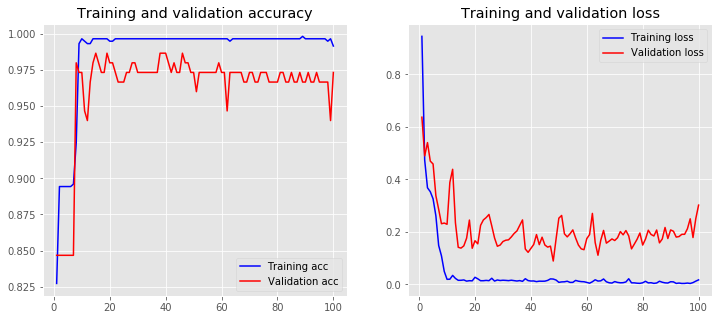

In [46]:
plot_history(history)

# Hyperparameter Tuning

In [47]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# # model.add(layers.Flatten())
# # model.add(layers.Dense(10, activation='relu'))
# # model.add(layers.Dense(3, activation='sigmoid'))
# model.add(layers.SpatialDropout1D(0.2))
# model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [48]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_lstm=100, dropout = 0.2, recurrent_dropout=0.2):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(n_dense, activation=activation))
#     model.add(layers.Dense(3, activation='sigmoid'))

    model.add(layers.SpatialDropout1D(dropout))
    model.add(layers.LSTM(n_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [49]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [25, 32, 40], 
          'epochs': [10,12,15],
          'learning_rate': [0.01, 0.001, 0.0005],
          'embedding_dim' : [10,15,20,25,30],
          'n_lstm' : [50,70,100,120],
          'dropout' : [0.1,0.15,0.2,0.25,0.3], 
          'recurrent_dropout' : [0.1,0.15,0.2,0.25,0.3]
         }

In [50]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [51]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [52]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
397/397 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.83 - 3s 8ms/step - loss: 0.8574 - accuracy: 0.8338
Epoch 2/10
397/397 [==============================] - 1s 3ms/step - loss: 0.4615 - accuracy: 0.8791
Epoch 3/10
397/397 [==============================] - 2s 5ms/step - loss: 0.3981 - accuracy: 0.8791
Epoch 4/10
397/397 [==============================] - 1s 4ms/step - loss: 0.3805 - accuracy: 0.8791
Epoch 5/10
397/397 [==============================] - 1s 4ms/step - loss: 0.3488 - accuracy: 0.8791
Epoch 6/10
397/397 [==============================] - 1s 3ms/step - loss: 0.2283 - accuracy: 0.8766
Epoch 7/10
397/397 [==============================] - 1s 3ms/step - loss: 0.1353 - accuracy: 0.9144
Epoch 8/10
397/397 [==============================] - 1s 3ms/step - loss: 0.0815 - accuracy: 0.9849
Epoch 9/10
397/397 [==============================] - 2s 4ms/step - loss: 0.0357 - accuracy: 0.9899
Epoch 10/10
397/397 [=================

397/397 [==============================] - 1s 3ms/step - loss: 0.1505 - accuracy: 0.9144
Epoch 10/12
397/397 [==============================] - 1s 3ms/step - loss: 0.0953 - accuracy: 0.9849
Epoch 11/12
397/397 [==============================] - 1s 3ms/step - loss: 0.0434 - accuracy: 0.9950
Epoch 12/12
397/397 [==============================] - 0s 903us/step
Epoch 1/12
397/397 [==============================] - 3s 8ms/step - loss: 0.9376 - accuracy: 0.8010
Epoch 2/12
397/397 [==============================] - 1s 3ms/step - loss: 0.4179 - accuracy: 0.8992
Epoch 3/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3427 - accuracy: 0.8992
Epoch 4/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3416 - accuracy: 0.8992
Epoch 5/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3359 - accuracy: 0.8992
Epoch 6/12
397/397 [==============================] - 2s 5ms/step - loss: 0.3253 - accuracy: 0.8992
Epoch 7/12
397/397 [====================

397/397 [==============================] - 3s 8ms/step - loss: 1.0163 - accuracy: 0.7733
Epoch 2/10
397/397 [==============================] - 1s 2ms/step - loss: 0.5550 - accuracy: 0.8992
Epoch 3/10
397/397 [==============================] - 1s 2ms/step - loss: 0.3730 - accuracy: 0.8992
Epoch 4/10
397/397 [==============================] - 1s 2ms/step - loss: 0.3483 - accuracy: 0.8992
Epoch 5/10
397/397 [==============================] - 1s 2ms/step - loss: 0.3515 - accuracy: 0.8992
Epoch 6/10
397/397 [==============================] - 1s 2ms/step - loss: 0.3385 - accuracy: 0.8992
Epoch 7/10
397/397 [==============================] - 1s 2ms/step - loss: 0.3222 - accuracy: 0.8992
Epoch 8/10
397/397 [==============================] - 1s 2ms/step - loss: 0.2715 - accuracy: 0.8992
Epoch 9/10
397/397 [==============================] - 1s 2ms/step - loss: 0.1739 - accuracy: 0.9018
Epoch 10/10
397/397 [==============================] - 0s 714us/step
Epoch 1/10
398/398 [======================

397/397 [==============================] - 1s 3ms/step - loss: 0.0244 - accuracy: 0.9950
Epoch 13/15
397/397 [==============================] - 1s 3ms/step - loss: 0.0254 - accuracy: 0.9950
Epoch 14/15
397/397 [==============================] - 1s 3ms/step - loss: 0.0244 - accuracy: 0.9950
Epoch 15/15
397/397 [==============================] - 0s 841us/step
Epoch 1/15
397/397 [==============================] - 3s 9ms/step - loss: 0.9545 - accuracy: 0.8967
Epoch 2/15
397/397 [==============================] - 1s 3ms/step - loss: 0.5166 - accuracy: 0.8992
Epoch 3/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3683 - accuracy: 0.8992
Epoch 4/15
397/397 [==============================] - 1s 4ms/step - loss: 0.3472 - accuracy: 0.8992
Epoch 5/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3407 - accuracy: 0.8992
Epoch 6/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3212 - accuracy: 0.8992
Epoch 7/15
397/397 [====================

397/397 [==============================] - 1s 2ms/step - loss: 0.3901 - accuracy: 0.8791
Epoch 7/12
397/397 [==============================] - 1s 2ms/step - loss: 0.3871 - accuracy: 0.8791
Epoch 8/12
397/397 [==============================] - 1s 2ms/step - loss: 0.3872 - accuracy: 0.8791
Epoch 9/12
397/397 [==============================] - 1s 2ms/step - loss: 0.3834 - accuracy: 0.8791
Epoch 10/12
397/397 [==============================] - 1s 2ms/step - loss: 0.3778 - accuracy: 0.8791
Epoch 11/12
397/397 [==============================] - 1s 2ms/step - loss: 0.3349 - accuracy: 0.8791
Epoch 12/12
397/397 [==============================] - 0s 612us/step
Epoch 1/12
397/397 [==============================] - 4s 9ms/step - loss: 1.0111 - accuracy: 0.8589
Epoch 2/12
397/397 [==============================] - 1s 2ms/step - loss: 0.6160 - accuracy: 0.8992
Epoch 3/12
397/397 [==============================] - 1s 2ms/step - loss: 0.4763 - accuracy: 0.8992
Epoch 4/12
397/397 [====================

397/397 [==============================] - 0s 758us/step
Epoch 1/15
397/397 [==============================] - 4s 10ms/step - loss: 1.0301 - accuracy: 0.7935
Epoch 2/15
397/397 [==============================] - 1s 2ms/step - loss: 0.5598 - accuracy: 0.8992
Epoch 3/15
397/397 [==============================] - 1s 2ms/step - loss: 0.4361 - accuracy: 0.8992
Epoch 4/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3545 - accuracy: 0.8992
Epoch 5/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3397 - accuracy: 0.8992
Epoch 6/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3353 - accuracy: 0.8992
Epoch 7/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3335 - accuracy: 0.8992
Epoch 8/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3088 - accuracy: 0.8992
Epoch 9/15
397/397 [==============================] - 1s 2ms/step - loss: 0.2566 - accuracy: 0.8992
Epoch 10/15
397/397 [=====================

Epoch 2/12
397/397 [==============================] - 1s 3ms/step - loss: 0.6232 - accuracy: 0.8992
Epoch 3/12
397/397 [==============================] - 1s 2ms/step - loss: 0.4043 - accuracy: 0.8992
Epoch 4/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3652 - accuracy: 0.8992
Epoch 5/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3579 - accuracy: 0.8992
Epoch 6/12
397/397 [==============================] - 2s 5ms/step - loss: 0.3368 - accuracy: 0.8992
Epoch 7/12
397/397 [==============================] - 2s 4ms/step - loss: 0.3336 - accuracy: 0.8992
Epoch 8/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3344 - accuracy: 0.8992
Epoch 9/12
397/397 [==============================] - 1s 3ms/step - loss: 0.3110 - accuracy: 0.8992
Epoch 10/12
397/397 [==============================] - 1s 3ms/step - loss: 0.2302 - accuracy: 0.8992
Epoch 11/12
397/397 [==============================] - 1s 3ms/step - loss: 0.1463 - accuracy: 0.899

397/397 [==============================] - 5s 12ms/step - loss: 1.0146 - accuracy: 0.8388
Epoch 2/15
397/397 [==============================] - 2s 5ms/step - loss: 0.6583 - accuracy: 0.8992
Epoch 3/15
397/397 [==============================] - 1s 3ms/step - loss: 0.4408 - accuracy: 0.8992
Epoch 4/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3612 - accuracy: 0.8992
Epoch 5/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3460 - accuracy: 0.8992
Epoch 6/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3388 - accuracy: 0.8992
Epoch 7/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8992
Epoch 8/15
397/397 [==============================] - 1s 2ms/step - loss: 0.3140 - accuracy: 0.8992
Epoch 9/15
397/397 [==============================] - 1s 2ms/step - loss: 0.2705 - accuracy: 0.8992
Epoch 10/15
397/397 [==============================] - 1s 3ms/step - loss: 0.1768 - accuracy: 0.9018
Epoch 11/

397/397 [==============================] - 5s 13ms/step - loss: 0.9487 - accuracy: 0.8237
Epoch 2/15
397/397 [==============================] - 2s 4ms/step - loss: 0.4149 - accuracy: 0.8791
Epoch 3/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3947 - accuracy: 0.8791
Epoch 4/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3949 - accuracy: 0.8791
Epoch 5/15
397/397 [==============================] - 1s 4ms/step - loss: 0.3768 - accuracy: 0.8791
Epoch 6/15
397/397 [==============================] - 2s 6ms/step - loss: 0.3324 - accuracy: 0.8791
Epoch 7/15
397/397 [==============================] - 3s 8ms/step - loss: 0.1742 - accuracy: 0.8816
Epoch 8/15
397/397 [==============================] - 2s 6ms/step - loss: 0.1177 - accuracy: 0.9244
Epoch 9/15
397/397 [==============================] - 2s 6ms/step - loss: 0.0653 - accuracy: 0.9950
Epoch 10/15
397/397 [==============================] - 1s 3ms/step - loss: 0.0379 - accuracy: 0.9924
Epoch 11/

398/398 [==============================] - 3s 9ms/step - loss: 0.2881 - accuracy: 0.9045
Epoch 9/12
398/398 [==============================] - 2s 5ms/step - loss: 0.1985 - accuracy: 0.9045
Epoch 10/12
398/398 [==============================] - 2s 5ms/step - loss: 0.1270 - accuracy: 0.9070
Epoch 11/12
398/398 [==============================] - 2s 5ms/step - loss: 0.0843 - accuracy: 0.9372
Epoch 12/12
398/398 [==============================] - 1s 1ms/step
Epoch 1/15
397/397 [==============================] - 5s 13ms/step - loss: 0.9262 - accuracy: 0.8287
Epoch 2/15
397/397 [==============================] - 1s 3ms/step - loss: 0.4206 - accuracy: 0.8791
Epoch 3/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3938 - accuracy: 0.8791
Epoch 4/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3875 - accuracy: 0.8791
Epoch 5/15
397/397 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8791
Epoch 6/15
397/397 [=====================

398/398 [==============================] - 6s 16ms/step - loss: 0.9790 - accuracy: 0.8367
Epoch 2/12
398/398 [==============================] - 1s 3ms/step - loss: 0.5234 - accuracy: 0.9045
Epoch 3/12
398/398 [==============================] - 1s 3ms/step - loss: 0.3756 - accuracy: 0.9045
Epoch 4/12
398/398 [==============================] - 1s 3ms/step - loss: 0.3250 - accuracy: 0.9045
Epoch 5/12
398/398 [==============================] - 1s 4ms/step - loss: 0.3235 - accuracy: 0.9045
Epoch 6/12
398/398 [==============================] - 2s 4ms/step - loss: 0.3126 - accuracy: 0.9045
Epoch 7/12
398/398 [==============================] - 1s 3ms/step - loss: 0.2802 - accuracy: 0.9045
Epoch 8/12
398/398 [==============================] - 1s 3ms/step - loss: 0.1780 - accuracy: 0.9045
Epoch 9/12
398/398 [==============================] - 1s 3ms/step - loss: 0.1106 - accuracy: 0.9045
Epoch 10/12
398/398 [==============================] - 1s 3ms/step - loss: 0.0826 - accuracy: 0.9724
Epoch 11/

In [53]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.0948030167520429 and Best Params:  {'recurrent_dropout': 0.2, 'n_lstm': 70, 'learning_rate': 0.01, 'epochs': 15, 'embedding_dim': 15, 'dropout': 0.15, 'batch_size': 25, 'activation': 'tanh'}


## Fit Best Model

In [54]:
model = create_model(learning_rate=0.01, activation='tanh', embedding_dim=15, n_lstm=70, dropout = 0.15, recurrent_dropout=0.2)

In [69]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=65,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=25)

In [70]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9667
Testing Accuracy:  0.9840


In [71]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

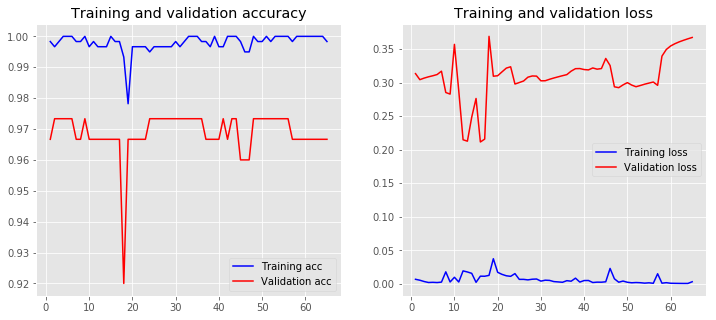

In [72]:
plot_history(history)

# Model Evaluation: Test Data

In [73]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9839572310447693


Confusion matrix, without normalization


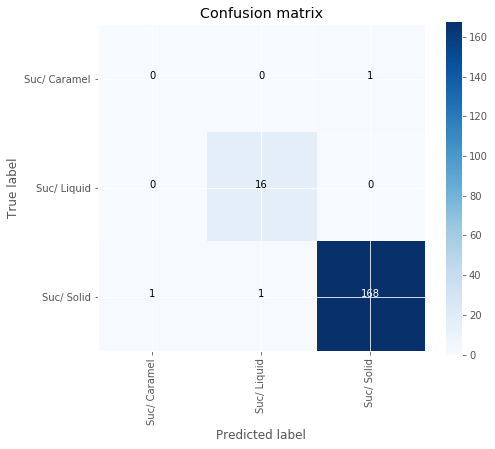

In [74]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [75]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9059671471672812

In [76]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,Suc/ Caramel,0.000000,0.000000,0.000000,1
1,Suc/ Liquid,0.941176,1.000000,0.969697,16
2,Suc/ Solid,0.994083,0.988235,0.991150,170


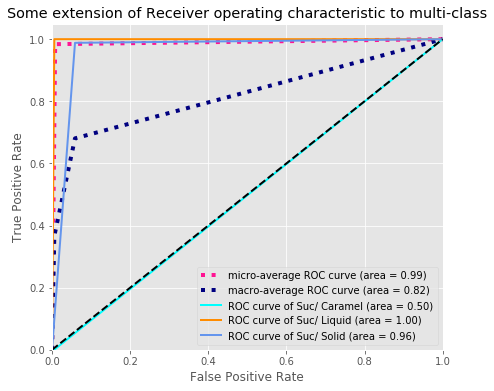

In [77]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [78]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.97


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.97')

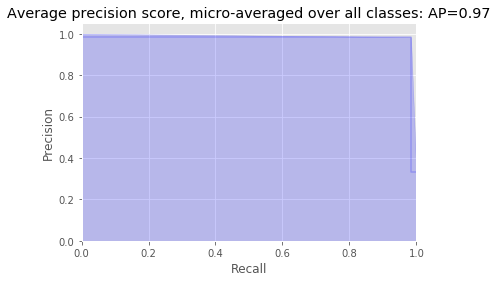

In [79]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

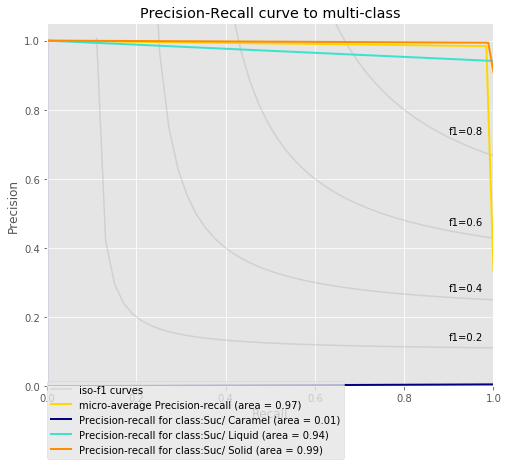

In [80]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()